# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [290]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [291]:
num_classes = 10
num_features = 784

learning_rate = 0.001
training_steps = 10000
batch_size = 256
display_step = 100

n_hidden_1 = 256
n_hidden_2 = 512

In [292]:
from keras.src.datasets import mnist

# Загрузка и подготовка данных
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
x_train, x_test = x_train / 255., x_test / 255.

# Перемешивание и подготовка данных
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.shuffle(5000).batch(batch_size).repeat().prefetch(tf.data.experimental.AUTOTUNE)


In [293]:
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name="w")
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NeuralNet(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.layer1 = DenseLayer(num_features, n_hidden_1, name='layer1')
        self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, name='layer2')
        self.out_layer = DenseLayer(n_hidden_2, num_classes, name='out_layer')

    def __call__(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.out_layer(x, activation=1)
        return x

In [294]:
def cross_entropy_loss(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_true, y_pred))

def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [295]:
neural_net = NeuralNet(name="mnist")
optimizer = tf.optimizers.Adam(learning_rate)

def train_step(neural_net, input_x, output_y):
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy_loss(pred, output_y)
        trainable_variables = neural_net.trainable_variables
        gradients = g.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss


In [296]:
loss_history = []
accuracy_history = []

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    loss = train_step(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        acc = accuracy(pred, batch_y).numpy()  # Преобразование тензора в число
        loss_history.append(loss.numpy())  # Преобразование тензора в число
        accuracy_history.append(acc)
        print(f"Step: {step}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

# Оценка модели на тестовых данных
test_pred = neural_net(x_test)
print(f"Точність на тестових даних: {accuracy(test_pred, y_test) * 100:.2f}%")

Step: 100, Loss: 1.9469, Accuracy: 0.5234
Step: 200, Loss: 1.8924, Accuracy: 0.5664
Step: 300, Loss: 1.7095, Accuracy: 0.7578
Step: 400, Loss: 1.7285, Accuracy: 0.7344
Step: 500, Loss: 1.6824, Accuracy: 0.7773
Step: 600, Loss: 1.6475, Accuracy: 0.8086
Step: 700, Loss: 1.6494, Accuracy: 0.8125
Step: 800, Loss: 1.6205, Accuracy: 0.8438
Step: 900, Loss: 1.5974, Accuracy: 0.8672
Step: 1000, Loss: 1.5690, Accuracy: 0.9023
Step: 1100, Loss: 1.5558, Accuracy: 0.9102
Step: 1200, Loss: 1.5596, Accuracy: 0.9102
Step: 1300, Loss: 1.5253, Accuracy: 0.9453
Step: 1400, Loss: 1.5338, Accuracy: 0.9336
Step: 1500, Loss: 1.5235, Accuracy: 0.9453
Step: 1600, Loss: 1.5181, Accuracy: 0.9492
Step: 1700, Loss: 1.5068, Accuracy: 0.9570
Step: 1800, Loss: 1.5051, Accuracy: 0.9648
Step: 1900, Loss: 1.4946, Accuracy: 0.9688
Step: 2000, Loss: 1.5099, Accuracy: 0.9570
Step: 2100, Loss: 1.5226, Accuracy: 0.9453
Step: 2200, Loss: 1.5122, Accuracy: 0.9492
Step: 2300, Loss: 1.5294, Accuracy: 0.9336
Step: 2400, Loss: 1.

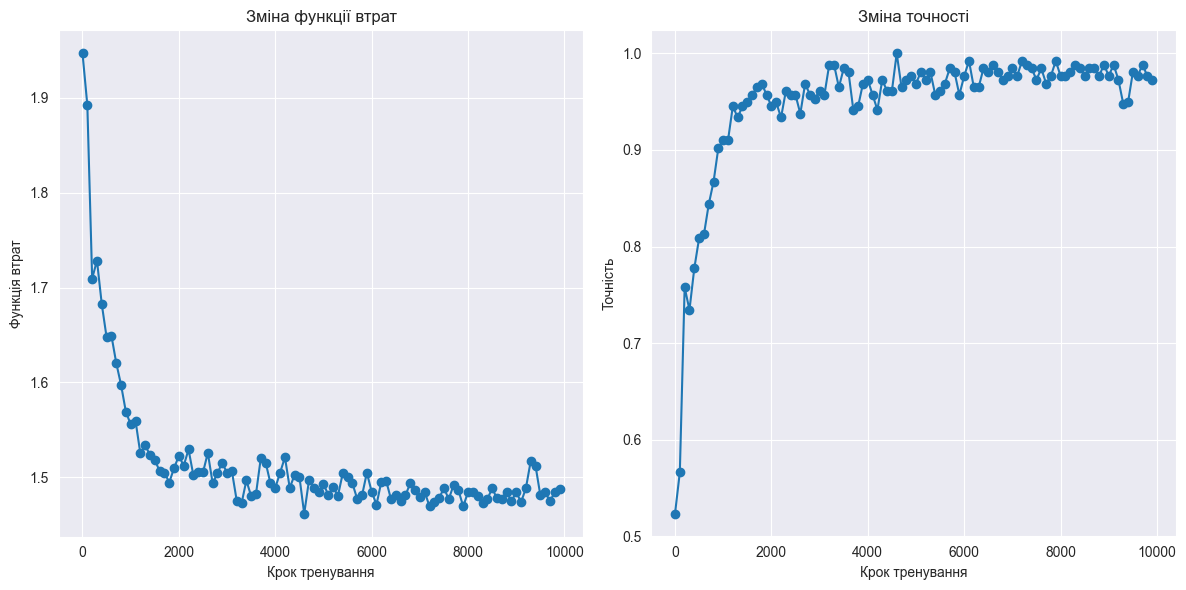

In [297]:
# Виведи графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведення графіка функції втрат
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, training_steps + 1, display_step), loss_history, marker='o', linestyle='-')
plt.title('Зміна функції втрат')
plt.xlabel('Крок тренування')
plt.ylabel('Функція втрат')

# Виведення графіка точності
plt.subplot(1, 2, 2)
plt.plot(range(1, training_steps + 1, display_step), accuracy_history, marker='o', linestyle='-')
plt.title('Зміна точності')
plt.xlabel('Крок тренування')
plt.ylabel('Точність')

plt.tight_layout()
plt.show()


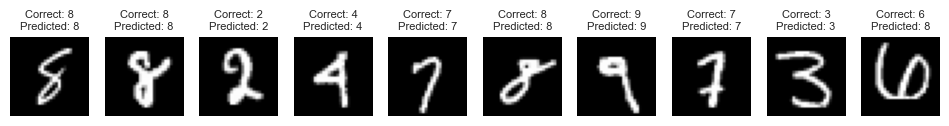

In [300]:
random_indices = random.sample(range(len(x_test)), 10)
test_images = x_test[random_indices]
test_labels = y_test[random_indices]

predictions = neural_net(test_images)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(test_images[i].reshape((28, 28)), cmap='gray')
    plt.title(f"Correct: {test_labels[i]}\nPredicted: {predicted_labels[i]}", fontsize=8)
    plt.axis('off')

plt.show()


In [301]:
correct_predictions = (predicted_labels == test_labels)
accuracy = sum(correct_predictions) / len(correct_predictions)
print(f"Accuracy on 10 images: {accuracy * 100:.2f}%")

Accuracy on 10 images: 90.00%
